# Facial feature keypoint detection

### Zac Carrico and Rich Ung


## Introduction
Facial feature keypoints are the location in space of facial features such as the tip of the nose, corner of the mouth, or center of the eye. Identifying these keypoints is trivial for humans, but challenging for computers. Different poses, nose sizes, gaze direction, etc., complicate facial feature keypoint detection for computers. Fortunately, advances in deep learning algorithms is continuing to improve the accuracy of facial keypoint detection. This report describes the applications of various learning algorithms to predicting facial keypoints.  
  
## Dataset
The data is from Kaggle's "Facial Keypoints Detection" dataset (https://www.kaggle.com/c/facial-keypoints-detection). The training data is 7,049 greyscale images of different people's faces and for each image there is facial keypoint information. Many of the facial keypoints are missing and if only non-missing value images are used, the dataset is 2,140 images.
  
Some of the images are repeated, such as a picture of Leonardo DiCaprio for which one observation has the correct keypoint locations and the other has completely erroneous keypoints. We discovered this after running many of our models so we decided to keep the erroneous data rather than retraining the models as this was time prohibitive.

## Models  
The best accuracy for image feature recognition is often obtained with neural networks. We compared fully-connected neural network models with convolutional neural network models and found that their performance depends on the dataset and number of training iterations (epochs).

### Fully-Connected Neural Networks

In a fully-connected neural network, each neuron is connected to every neuron in the previous layer, where each connection has its own weight. We have multiple hyperparameters that we can alter within a fully-connected network, which include: 
* Number of hidden layers
  * Our baseline model has a hidden layer, and we compared it to alternative models with more hidden layers
* Number of nodes per layer
  * Our baseline model has 100 neurons within its hidden layer. We first explore increasing that amount to 500 neurons within the Fully-Connected 500 Neural Network below.
* Type of activation function
  * There are many types of activation functions that we can use for our neural network (Sigmoid, Tanh, ReLU, etc.). While this provides us with many combinations of neural networks, especially since we can have a different activation function for every layer, we decided to keep it simple and use the "ReLU" activation funciton (f(x) = max(0,x)) for our FC hidden layers. After doing some research, it seems that training via ReLU is computationally faster and can prevent overfitting (the max function is a simple computation and negative values automatically become 0).

We explore two alternatives to our baseline 100 neuron model, one for which we increase the amount of neurons within the hidden layer (Fully-Connected 500 Neural Network), and another for which we add an additional hidden layer to the network (2 Layers of Fully-Connected 500 Neural Network):

### Convolutional Neural Networks

Unlike fully-connected neural networks, convolutional neural networks have neurons which connect to a local subset of neurons from the previous layer. This allows neurons to model key points within a section of an image, such as an edge or shape. This makes convolutional neural networks work well for images, and there are multiple hyperparameters that we can alter for CNNs:
* Depth
  * This is how many filters we would like per layer. Our first CNN model has a depth of 32, while our second CNN model has three layers with a depth of 32, 64, and 128 respectively. While we can alter the amount of filters per layer, we decided to increase the amount of filters to help better train our model.
* Stride
  * This is how many pixels we move when we slide the filter. We keep this at 1 for all of our CNN models since we are already down-sampling within our Pooling layers (see below).
* Zero-Padding
  * This is padding the input volume with zeros around the border, which helps to control the spatial size of the output. However, we do not do any zero-padding in our model since the spatial size and stride fits nicely with the input of our layer.
* Type of activation function
  * For similar reasons as our fully-connected neural network, we decided to use the ReLU activation function for all of our layers.
  
We can also insert a pooling layer in between successive convolutional layers in order to reduce the spatial size of the output and control for overfitting. We decided to place a pooling layer after every convolutional layer in order to help generalize our models. Pooling provides us with the following hyperparameters: 
* Operation (Max, Average, Min)
  * We use the Max operation on all of our pooling layers to help regularize and quickly train our data.
* Spatial Size Reduction and Stride
  * We use a spatial size of 2x2 and a stride of 2 for all of our pooling layers, and this is a commonly used stride so we kept it constant.

## Our Environment

* Python 3
* TensorFlow
  * An open source software library for numerical computation using data flow graphs.
  * It is similar to Theano, where it is a neural network library that we can use to create neural nets.
* Keras
  * A Python Deep Learning library that can run on top of TensorFlow in order to easily create neural network models
* Amazon Elastic Compute Cloud Instance (AWS EC2 Instance)
  * AMI Name: Deep Learning AMI with Conda (Ubuntu)
    * AMI ID: ami-405ade3a
    * Python Conda Environment Name: conda_tensorflow_p36
    * Additional Packages Installed
      * scikit-learn
      * graphviz
        * Note that we also have to `pip install graphviz` in addition to installing this package on the anaconda environment
      * pydotplus
* Colaboratory
  * Colaboratory allows us to share a Jupyter notebook and make edits simultaneously
  * We used Colaboratory (https://colab.research.google.com) when writing our combined, final Jupyter notebook
  * We would then test our notebook through downloading the .ipynb file and running it on our EC2 instance
    
    
Set-Up Instructions can be found at the Appendix section located at the bottom of this notebook. 

## Loading the Dataset and Creating The Baseline Model

### Loading the Dataset

First we import the necessary packages that we use for this notebook

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt

# Printing Keras, TensorFlow, and Python version for recordkeeping
import keras
print("Keras Version:", keras.__version__)
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
import sys
print("Python Version:", sys.version)

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Keras Version: 2.1.0
TensorFlow Version: 1.4.0
Python Version: 3.6.3 |Anaconda, Inc.| (default, Nov  9 2017, 00:19:18) 
[GCC 7.2.0]


We then use the following load function in order to load our dataset.

In [2]:
%%time

FTRAIN = 'https://s3.amazonaws.com/w207-rich/training.csv'
FTEST = 'https://s3.amazonaws.com/w207-rich/test.csv'

def load(test=False, cols=None, drop_na=True, full_train_dev='Full'):
    """If test is true, read data from FTEST and if False, read from FTRAIN.
    If a list is passed to cols, only data about that column is returned."""
    
    fname = FTEST if test else FTRAIN
    df = read_csv(fname) # Reads the CSV into a Pandas dataframe

    if full_train_dev == 'Full':
        # Keep the all of the training data for the training set
        # (Useful when models already do validation split)
        pass
    else:
        df_train, df_dev = train_test_split(df, test_size=0.25, random_state=42)
        if full_train_dev == 'Train':
            df = df_train
        elif full_train_dev == 'Dev':
            df = df_dev
        else:
            raise Exception('Need a valid full_train_dev parameter')
    
    # Each observation has an image associated with it and the original data has the image pixels separated by spaces
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' ')) # Image originally encoded with spaces

    # Collecting specific columns based on user input.
    if cols:
        df = df[list(cols) + ['Image']]

    print(df.count()) # Print the number of observations for each column
    if drop_na:
        df = df.dropna() # Filter the dataframe to rows containing no missing values

    # Normalize the pixels which have intensity values from 0-255
    # Then assign these values to X
    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)
    
    # If test = False (default), regression output values will be assigned to y
    if not test:  
        # The features of interest that will be predicted are all those in the df besides image
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # Normalize y values to [-1, 1]
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

# Load initial dataset and print results
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

### Running baseline model

Our baseline model is a simple fully connected neural network with a single, 100-node hidden layer. We chose the Stochastic gradient descent optimizer because of its speed, a 0.01 standard learning rate ('lr'), and 0.9 momentum. We set Nesterov accelerated gradient descent to true to accelerate descent, and set the model to run 500 epochs, but use early stopicking in the case the validation loss does not improve by 0.00005 after 75 epochs.

In [3]:
%%time
NN_100neurons = Sequential()
# Taking in 9216 features as our input layer, then outputting to a 100-node layer
# 9216 comes from the amount of pixels within the image
NN_100neurons.add(Dense(100, input_dim=9216))
NN_100neurons.add(Activation('relu')) # Using a high performing activation filter for our neural network
NN_100neurons.add(Dense(30)) # Outputing 30 nodes, which is the number of outputs in the model

# Using SGD (Stochastic Gradient Descent)
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=75)
NN_100neurons.compile(loss='mean_squared_error', optimizer=sgd)
hist_NN_100neurons = NN_100neurons.fit(X, y, epochs=500, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# saving the model
json_string = NN_100neurons.to_json()
open('NN_100neurons_architecture.json', 'w').write(json_string)
NN_100neurons.save_weights('NN_100neurons_weights.h5')

CPU times: user 2min 24s, sys: 15.4 s, total: 2min 39s
Wall time: 1min 52s


#### Calculating Root Mean Squared Error (RMSE)

Root Mean Squared Error (RMSE) is the evaluation metric on Kaggle, for which the lower the RMSE, the better the score.

In order to calculate RMSE, we take the square root of the validation loss (Validation loss calculates the Mean Squared Error of the validation dataset). We then multiply the RMSE by 48 in order to denormalize the coordinates (since we normalized the y-values when we loaded the dataset) and compare it to the kaggle leaderboard.

In [4]:
print("RMSE: ",np.sqrt(hist_NN_100neurons.history['val_loss'][-1]) * 48)

RMSE:  2.48979665406


 This value is still far from the top kaggle scoreboard value of 1.28236 so we have much room for improvement and we will identify the key metrics for improvement by exploring alternative models.

### Fully-Connected 500 Neural Network

In [5]:
%%time
NN_500neurons = Sequential()
# Taking in 9216 features as our input layer, then outputting to a 100-node layer
# 9216 comes from the amount of pixels within the image
NN_500neurons.add(Dense(500, input_dim=9216))
NN_500neurons.add(Activation('relu')) # Using a high performing activation filter for our neural network
NN_500neurons.add(Dense(30)) # Outputing 30 nodes, which is the number of outputs in the model

# Using SGD (Stochastic Gradient Descent)
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=75)
NN_500neurons.compile(loss='mean_squared_error', optimizer=sgd)
hist_NN_500neurons = NN_500neurons.fit(X, y, epochs=500, validation_split=0.2, callbacks=[early_stopping], verbose=0)
print("RMSE: ",np.sqrt(hist_NN_500neurons.history['val_loss'][-1]) * 48)

# saving the model
json_string = NN_500neurons.to_json()
open('NN_500neurons_architecture.json', 'w').write(json_string)
NN_500neurons.save_weights('NN_500neurons_weights.h5')

RMSE:  2.43398839911
CPU times: user 2min 55s, sys: 23.9 s, total: 3min 19s
Wall time: 2min 24s


We see a small decrease in the RMSE from 2.49 to 2.43 when increasing the amount of neurons from 100 to 500. The compute time longer by about a minute.

### 2 Layers of Fully-Connected 500 Neural Network

In [6]:
%%time
# 2x500 dense neural layer
NN_2x500neurons = Sequential()
# Taking in 9216 features as our input layer, then outputting to a 100-node layer
# 9216 comes from the amount of pixels within the image
NN_2x500neurons.add(Dense(500, input_dim=9216))
NN_2x500neurons.add(Activation('relu'))
NN_2x500neurons.add(Dense(500, input_dim=9216))
NN_2x500neurons.add(Activation('relu'))
NN_2x500neurons.add(Dense(30)) # Outputing 30 nodes, which is the number of outputs in the model

# Using SGD (Stochastic Gradient Descent)
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=75)
NN_2x500neurons.compile(loss='mean_squared_error', optimizer=sgd)
hist_NN_2x500neurons = NN_2x500neurons.fit(X, y, epochs=500, validation_split=0.2, callbacks=[early_stopping], verbose=0)
print("RMSE: ",np.sqrt(hist_NN_2x500neurons.history['val_loss'][-1]) * 48)

# saving the model
json_string = NN_2x500neurons.to_json()
open('NN_2x500neurons_architecture.json', 'w').write(json_string)
NN_2x500neurons.save_weights('NN_2x500neurons_weights.h5')

RMSE:  2.39178275919
CPU times: user 2min 9s, sys: 16.7 s, total: 2min 26s
Wall time: 1min 47s


We see a small decrease in the RMSE with the addition of another neural layer, but the compute time was about the same (or even faster).

### 1 Convolutional Layer, 2 Layers of FC 500 Neural Network

First, in order to process our images through convolutional layers, we define another load function in order to transform our dataset into a 2D dataset. We next explore 2 different convolutional neural network models below:

In [7]:
# Define another load function to load data and reshape into 2D
def load2d(test=False, cols=None, drop_na=True, full_train_dev='Full'):
    X, y = load(test, cols, drop_na, full_train_dev)
    X = X.reshape(-1, 96, 96, 1)
    return X, y

In [8]:
%%time
X2d, y2d = load2d()
CNN_1CN_2x500neurons = Sequential()
CNN_1CN_2x500neurons.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
CNN_1CN_2x500neurons.add(Activation('relu'))
CNN_1CN_2x500neurons.add(MaxPooling2D(pool_size=(2, 2)))

CNN_1CN_2x500neurons.add(Flatten())
CNN_1CN_2x500neurons.add(Dense(500))
CNN_1CN_2x500neurons.add(Activation('relu'))
CNN_1CN_2x500neurons.add(Dense(500))
CNN_1CN_2x500neurons.add(Activation('relu'))
CNN_1CN_2x500neurons.add(Dense(30))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=75)
CNN_1CN_2x500neurons.compile(loss='mean_squared_error', optimizer=sgd)
hist_CNN_1CN_2x500neurons = CNN_1CN_2x500neurons.fit(X2d,
                                                     y2d,
                                                     epochs=500,
                                                     validation_split=0.2,
                                                     callbacks=[early_stopping],
                                                     verbose = 0)
print("RMSE: ",np.sqrt(hist_CNN_1CN_2x500neurons.history['val_loss'][-1]) * 48)

# saving the model
json_string = CNN_1CN_2x500neurons.to_json()
open('CNN_1CN_2x500neurons_architecture.json', 'w').write(json_string)
CNN_1CN_2x500neurons.save_weights('CNN_1CN_2x500neurons_weights.h5')

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

There is a huge decrease in RMSE when using a convolutional neural layer (by about 0.54), however the compute time dramatically increased to 10 minutes.

### 3 Convolutional Layers, 2 Layers of FC Neural Network

In [9]:
%%time
CNN_3CN_2x500neurons = Sequential()
CNN_3CN_2x500neurons.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
CNN_3CN_2x500neurons.add(Activation('relu'))
CNN_3CN_2x500neurons.add(MaxPooling2D(pool_size=(2, 2)))

CNN_3CN_2x500neurons.add(Conv2D(64, (2, 2)))
CNN_3CN_2x500neurons.add(Activation('relu'))
CNN_3CN_2x500neurons.add(MaxPooling2D(pool_size=(2, 2)))

CNN_3CN_2x500neurons.add(Conv2D(128, (2, 2)))
CNN_3CN_2x500neurons.add(Activation('relu'))
CNN_3CN_2x500neurons.add(MaxPooling2D(pool_size=(2, 2)))

CNN_3CN_2x500neurons.add(Flatten())
CNN_3CN_2x500neurons.add(Dense(500))
CNN_3CN_2x500neurons.add(Activation('relu'))
CNN_3CN_2x500neurons.add(Dense(500))
CNN_3CN_2x500neurons.add(Activation('relu'))
CNN_3CN_2x500neurons.add(Dense(30))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=75)
CNN_3CN_2x500neurons.compile(loss='mean_squared_error', optimizer=sgd)
hist_CNN_3CN_2x500neurons = CNN_3CN_2x500neurons.fit(X2d,
                                                     y2d,
                                                     epochs=500,
                                                     validation_split=0.2,
                                                     callbacks=[early_stopping],
                                                     verbose=0)
print("RMSE: ",np.sqrt(hist_CNN_3CN_2x500neurons.history['val_loss'][-1]) * 48)

# saving the model
json_string = CNN_3CN_2x500neurons.to_json()
open('CNN_3CN_2x500neurons_architecture.json', 'w').write(json_string)
CNN_3CN_2x500neurons.save_weights('CNN_3CN_2x500neurons_weights.h5')

RMSE:  1.7741654384
CPU times: user 11min 30s, sys: 1min 53s, total: 13min 23s
Wall time: 15min 28s


We can see that the RMSE decreased even further, and the compute time increased by about 1.5x compared to when we ran a 1 convolutional neural network.

### Graphing Validation Loss over Epochs

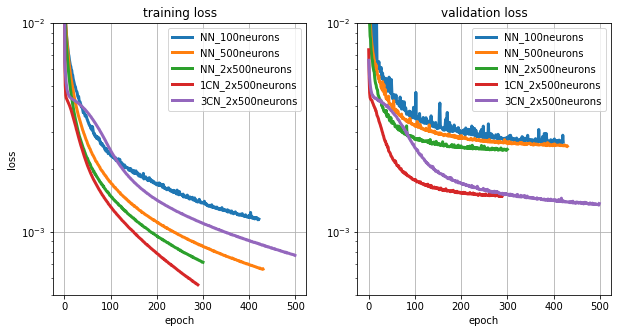

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(hist_NN_100neurons.history['loss'], linewidth=3, label='NN_100neurons')
plt.plot(hist_NN_500neurons.history['loss'], linewidth=3, label='NN_500neurons')
plt.plot(hist_NN_2x500neurons.history['loss'], linewidth=3, label='NN_2x500neurons')
plt.plot(hist_CNN_1CN_2x500neurons.history['loss'], linewidth=3, label='1CN_2x500neurons')
plt.plot(hist_CNN_3CN_2x500neurons.history['loss'], linewidth=3, label='3CN_2x500neurons')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(5e-4, 1e-2)
plt.yscale('log')
plt.legend(loc='upper right')
plt.title("training loss")


plt.subplot(1, 2, 2)
plt.plot(hist_NN_100neurons.history['val_loss'], linewidth=3, label='NN_100neurons')
plt.plot(hist_NN_500neurons.history['val_loss'], linewidth=3, label='NN_500neurons')
plt.plot(hist_NN_2x500neurons.history['val_loss'], linewidth=3, label='NN_2x500neurons')
plt.plot(hist_CNN_1CN_2x500neurons.history['val_loss'], linewidth=3, label='1CN_2x500neurons')
plt.plot(hist_CNN_3CN_2x500neurons.history['val_loss'], linewidth=3, label='3CN_2x500neurons')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylim(5e-4, 1e-2)
plt.yscale('log')
plt.legend(loc='upper right')
plt.title("validation loss")
plt.show()

There's a difference between the number of epochs for each model due to early stopping. We can see that the 3CN_2x500 neurons's validation loss has yet to plateau versus the other models, showing that it is possible for the 3CN_2x500 neurons model to continue improving with more epochs. A full comparison of the models is made in the summary section below.

### Plotting predicted points on images

Now we use the neural network to predict facial feature locatons and display a sample of the results on the images for a visual check. It does well for many features, especially the nose, eye center, and corners of the eyes, but does less well with eyebrow outer corners.

ImageId    1783
Image      1783
dtype: int64


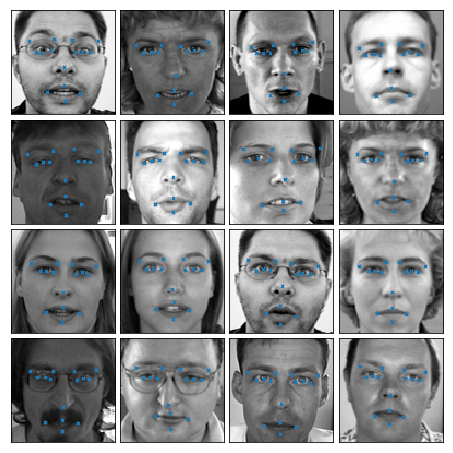

In [11]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96) # creates a 96x96 matrix from the array
    axis.imshow(img, cmap='gray')
    # the scaled position is converted back to a pixel location by multiplying by 48 and adding 48.
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X_test, _ = load2d(test=True)
y_test = CNN_3CN_2x500neurons.predict(X_test)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

plt.show()

### Dealing with Missing Labels

One thing we noticed is that a lot of the observations have missing regression outputs. While we have 7049 observations, we found that only 2140 have 30 complete labels, and most observations are missing at least 1 of the regression output labels. Initially, we decided to temporarily drop all NaN values in order to simplify and properly analyze the dataset. Now, we would like to consider as many of the 7049 observations as possible within our model, not just the 2140 complete observations.

Since we have 30 regression outputs, we can split our model into multiple models, one model for each group of regression outputs. That way, each neural network model fits into a subset of regression outputs, and gives us the flexiblity to fit more complete observations within each model. For example:

![y-values Example](https://raw.githubusercontent.com/ZacCarrico/facial-keypoint-convolutional-neural-network/master/images/y-examples.png)

Pretend those are all the y-labels for our dataset. Right now, all the models only look at the blue data, because those are the only rows with complete y-label values. If we model for only the first 4 columns (first 4 regression output labels), we would then be able to use both the blue *and* orange rows as part of our training set (we have "complete observations" for the orange part, and the green won't be part of the training set because we have NA values for those columns)

First, we split the 30 regression outputs into 6 subgroups which were chosen based on how many complete observations we can obtain within each subgroup. For example, the eye_center metrics share 7036 complete rows, far more than any of the other features so they naturally formed their own subgroup.

In [12]:
subgroup = {}
subgroup['eye_center'] = {}
subgroup['eye_center']['labels'] = ['left_eye_center_x',
                                    'left_eye_center_y',
                                    'right_eye_center_x',
                                    'right_eye_center_y']
subgroup['eye_corners'] = {}
subgroup['eye_corners']['labels'] = ['left_eye_inner_corner_x',
                                     'left_eye_inner_corner_y',
                                     'left_eye_outer_corner_x',
                                     'left_eye_outer_corner_y',
                                     'right_eye_inner_corner_x',
                                     'right_eye_inner_corner_y',
                                     'right_eye_outer_corner_x',
                                     'right_eye_outer_corner_y']
subgroup['eyebrow'] = {}
subgroup['eyebrow']['labels'] = ['left_eyebrow_inner_end_x',
                                 'left_eyebrow_inner_end_y',
                                 'left_eyebrow_outer_end_x',
                                 'left_eyebrow_outer_end_y',
                                 'right_eyebrow_inner_end_x',
                                 'right_eyebrow_inner_end_y',
                                 'right_eyebrow_outer_end_x',
                                 'right_eyebrow_outer_end_y']
subgroup['nose_tip'] = {}
subgroup['nose_tip']['labels'] = ['nose_tip_x',
                                  'nose_tip_y']
subgroup['mouth_upper'] = {}
subgroup['mouth_upper']['labels'] = ['mouth_left_corner_x',
                                     'mouth_left_corner_y',
                                     'mouth_right_corner_x',
                                     'mouth_right_corner_y',
                                     'mouth_center_top_lip_x',
                                     'mouth_center_top_lip_y']
subgroup['mouth_bottom'] = {}
subgroup['mouth_bottom']['labels'] = ['mouth_center_bottom_lip_x',
                                      'mouth_center_bottom_lip_y']

for key in subgroup.keys():
    print("Loading subgroup:",key)
    subgroup[key]['X'], subgroup[key]['y'] = load2d(cols = subgroup[key]['labels'], full_train_dev = 'Train')

Loading subgroup: eye_center
left_eye_center_x     5277
left_eye_center_y     5277
right_eye_center_x    5276
right_eye_center_y    5276
Image                 5286
dtype: int64
Loading subgroup: eye_corners
left_eye_inner_corner_x     1676
left_eye_inner_corner_y     1676
left_eye_outer_corner_x     1673
left_eye_outer_corner_y     1673
right_eye_inner_corner_x    1677
right_eye_inner_corner_y    1677
right_eye_outer_corner_x    1678
right_eye_outer_corner_y    1678
Image                       5286
dtype: int64
Loading subgroup: eyebrow
left_eyebrow_inner_end_x     1678
left_eyebrow_inner_end_y     1678
left_eyebrow_outer_end_x     1643
left_eyebrow_outer_end_y     1643
right_eyebrow_inner_end_x    1678
right_eyebrow_inner_end_y    1678
right_eyebrow_outer_end_x    1652
right_eyebrow_outer_end_y    1652
Image                        5286
dtype: int64
Loading subgroup: nose_tip
nose_tip_x    5286
nose_tip_y    5286
Image         5286
dtype: int64
Loading subgroup: mouth_upper
mouth_left_

Please note that, unlike previous models, we use `full_train_dev = 'Train'`. Previously, our model consisted of one neural network, which contained a validation_loss parameter that we can pull to calculate our RMSE. However, our model now consists of multiple, independent neural networks, and since each model fits the data differently, we cannot simply pull out each model's validation_loss parameter in order to calculate the total RSME anymore. So we split the data even further, creating a training dataset (subset) to train our multiple neural networks, and another validation dataset to run over our multiple neural networks and manually calculate the RMSE based on the predictions.

Now that we loaded the training data for each subgroup, we now create and fit a neural network model for each of these subgroups:

In [13]:
def model_template(num_outputs = 30):
    CNN_3CN_2x500neurons = Sequential()
    CNN_3CN_2x500neurons.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
    CNN_3CN_2x500neurons.add(Activation('relu'))
    CNN_3CN_2x500neurons.add(MaxPooling2D(pool_size=(2, 2)))

    CNN_3CN_2x500neurons.add(Conv2D(64, (2, 2)))
    CNN_3CN_2x500neurons.add(Activation('relu'))
    CNN_3CN_2x500neurons.add(MaxPooling2D(pool_size=(2, 2)))

    CNN_3CN_2x500neurons.add(Conv2D(128, (2, 2)))
    CNN_3CN_2x500neurons.add(Activation('relu'))
    CNN_3CN_2x500neurons.add(MaxPooling2D(pool_size=(2, 2)))

    CNN_3CN_2x500neurons.add(Flatten())
    CNN_3CN_2x500neurons.add(Dense(500))
    CNN_3CN_2x500neurons.add(Activation('relu'))
    CNN_3CN_2x500neurons.add(Dense(500))
    CNN_3CN_2x500neurons.add(Activation('relu'))
    CNN_3CN_2x500neurons.add(Dense(num_outputs))

    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=75)
    CNN_3CN_2x500neurons.compile(loss='mean_squared_error', optimizer=sgd)
    return CNN_3CN_2x500neurons

for key in subgroup.keys():
    # Note that this part of the code will take a while to run
    print("Training subgroup:",key)
    subgroup[key]['model'] = KerasRegressor(build_fn = model_template,
                                            num_outputs = subgroup[key]['y'].shape[1],
                                            epochs = 500)
    subgroup[key]['model'].fit(subgroup[key]['X'],
                               subgroup[key]['y'],
                               validation_split=0.2,
                               callbacks=[early_stopping],
                               verbose = 0)

Training subgroup: eye_center
Training subgroup: eye_corners
Training subgroup: eyebrow
Training subgroup: nose_tip
Training subgroup: mouth_upper
Training subgroup: mouth_bottom


We then predict and calculate the score for this model:

In [14]:
X_dev, y_dev = load2d(full_train_dev = 'Dev')

for key in subgroup.keys():
    subgroup[key]['y_dev_pred'] = subgroup[key]['model'].predict(X_dev)

# Predict and score using models
y_dev_pred = np.hstack((subgroup[key]['y_dev_pred'] for key in subgroup.keys()))
score = mean_squared_error(y_dev,y_dev_pred)
print("RMSE: ",np.sqrt(score) * 48)

left_eye_center_x            1762
left_eye_center_y            1762
right_eye_center_x           1760
right_eye_center_y           1760
left_eye_inner_corner_x       595
left_eye_inner_corner_y       595
left_eye_outer_corner_x       594
left_eye_outer_corner_y       594
right_eye_inner_corner_x      591
right_eye_inner_corner_y      591
right_eye_outer_corner_x      590
right_eye_outer_corner_y      590
left_eyebrow_inner_end_x      592
left_eyebrow_inner_end_y      592
left_eyebrow_outer_end_x      582
left_eyebrow_outer_end_y      582
right_eyebrow_inner_end_x     592
right_eyebrow_inner_end_y     592
right_eyebrow_outer_end_x     584
right_eyebrow_outer_end_y     584
nose_tip_x                   1763
nose_tip_y                   1763
mouth_left_corner_x           591
mouth_left_corner_y           591
mouth_right_corner_x          590
mouth_right_corner_y          590
mouth_center_top_lip_x        594
mouth_center_top_lip_y        594
mouth_center_bottom_lip_x    1755
mouth_center_b

## Summary of Findings

### Comparison of Models  
We started with our baseline model (1 neural layer) and took an additive approach to explore what happens when additional layers are added or altered. The model comparison goes from one 100 neuron layer ("NN_100neurons") to a 500 neuronal layer ("NN_500neurons"), and then 2x500 neuron layers ("NN_2x500neurons"), before adding a single convolutional layer ("CNN_1CN_2x500neurons"), and ending with the final model of 3xconvolutonal layers and 2x500 neuron layers ("CNN_3CN_2x500neurons"). There are several notable conclusions that can be made from this comparison.  

* The relative perfomance of models is the same for the training and validation data   
* The 1CN_2x500neurons model has the fastest decrease in validation loss
* The NN_100neurons (the simplest model) has the slowest decrease in validation loss
* The 3CN_2x500neurons model takes the largest number of epochs to plateau
* Increasing the number of neurons and adding an additional neural layer decreases loss  
* The 3CN_2x500neurons model has the least amount of overfitting on the training data (since it has the smallest line gap between the training loss and validation loss)

![Loss comparison](https://raw.githubusercontent.com/ZacCarrico/facial-keypoint-convolutional-neural-network/master/images/loss-graph.png)

| Model                              | Training Time | RMSE          |
| ---------------------------------- |:-------------:| -------------:|
| NN_100neurons                      | 1min 52s      | 2.48979665406 |
| NN_500neurons                      | 2min 24s      | 2.43398839911 |
| NN_2x500neurons                    | 1min 47s      | 2.39178275919 |
| CNN_1CN_2x500neurons               | 10min 40s     | 1.84940840725 |
| CNN_3CN_2x500neurons               | 15min 28s     | 1.7741654384  |
| CNN_3CN_2x500neurons (multi-model) | ~1 hour       | 1.81636297703 |

We decided to use the CNN_3CN_2x500neurons as our primary model going forward because it had the least overfitting, and thus should generalize better. We also found that the multi-model version of our CNN_3CN_2x500neurons has a higher RMSE, and theoretically this means that we should use the single model version of our CNN_3CN_2x500neuron model. Because we were curious, we decided to submit our base model, CNN_3CN_2x500neurons single model, and CNN_3CN_2x500neurons multi-models into the Kaggle competition. The key descriptors of the CNN_3CN_2x500neuron model is the following.

#### Layer numbers and their effect for the CNN_3CN_2x500neurons model:  
1. simply the image, a 96x96 array  
2. first convolution: 32 outputs, 3x3 kernel  
3. first activation: Relu activation function  
4. first pooling: max pooling, 2x2 pooling window  
5. second convolution: 64 outputs, 2x2 kernel  
6. second activation: Relu activation function  
7. second pooling: max pooling, 2x2 pooling window  
8. third convolution: 128 outpus, 2x2 kernel  
9. third activation: Relu activation function  
10. third pooling: max pooling, 2x2 kernel  
11. first 1D neural layer: takes the 128 2D output and converts to a 1D 15,488 component vector  
12. second 1D neural layer: 500 outputs, dense (meaning it takes all inputs from the previous layer)  
13. first activation of 1D neural layer: Relu activation function  
14. third 1D neural layer: 500 outputs, dense  
15. second activation of 1D neural layer: Relu activation function  
16. third 1D neural layer: 30 outputs, dense  
  
    
The stochastic gradient descent parameters were chosen based on their good performance on previous neural networks.  

## Kaggle Submission

We will now run our test dataset through our final model and see how well it does on Kaggle

In [15]:
X, y = load2d(test=True)

for key in subgroup.keys():
    subgroup[key]['y_pred'] = subgroup[key]['model'].predict(X)

# Create prediction values
y_pred = np.hstack((subgroup[key]['y_pred'] for key in subgroup.keys()))

# Gather column names
columns = []
for key in subgroup.keys():
    for k in subgroup[key]['labels']:
        columns.append(k)

# Denormalize the prediction values
# (Remember that we normalized the y values to get a better model)
y_pred1 = y_pred * 48 + 48
y_pred2 = y_pred1.clip(0, 96)
predictions = pd.DataFrame(y_pred2, columns = columns)

# Read lookup table to create submission file
lookup_table = read_csv("https://s3.amazonaws.com/w207-rich/IdLookupTable.csv")

# Create submission file based on lookup table
values = []
for index, row in lookup_table.iterrows():
    values.append((
            row['RowId'],
            predictions.loc[predictions.index[row['ImageId'] - 1],row['FeatureName']]
            ))
submission = pd.DataFrame(values, columns=('RowId', 'Location'))
submission.to_csv("submission.csv", index=False)

ImageId    1783
Image      1783
dtype: int64


We submitted 3 files for our Kaggle competition: one with our base model, one with our CNN_3CN_2x500neurons model, and one with our multiple CNN_3CN_2x500neurons models. Below are the results:

| Model                              | Public Score  | Public Rank   | Private Score | Private Rank |
| ---------------------------------- |:-------------:| -------------:| -------------:|-------------:|
| NN_100neurons                      | 3.03975       | 57            | 3.41315       | 81           |
| CNN_3CN_2x500neurons               | 3.13868       | 58            | 3.22989       | 71           |
| CNN_3CN_2x500neurons (multi-model) | 2.32913       | 45            | 2.58974       | 53           |

We can see that although the CNN_3CN_2x500neurons single model had a lower RMSE during validation training, the CNN_3CN_2x500neurons multi-model performed better in the Kaggle competition, giving us the best rank out of the three models. This shows that the combination of multiple models performed better than the individual model.

## Lessons Learned

#### Dropout

Alongside the above techniques, we can also randomly set a fraction of the input units to 0 at each update during training time. This is called dropout, and helps prevent overfitting. We can add dropout layers into our model below to see if it improve RMSE, however we decided against using this for our final model since we are already reduce overfitting through our Pooling layers.

In [16]:
%%time
CNN_3CN_2x500neurons_dropout = Sequential()
CNN_3CN_2x500neurons_dropout.add(Conv2D(32, (3, 3), input_shape=(96, 96, 1)))
CNN_3CN_2x500neurons_dropout.add(Activation('relu'))
CNN_3CN_2x500neurons_dropout.add(MaxPooling2D(pool_size=(2, 2)))

CNN_3CN_2x500neurons_dropout.add(Conv2D(64, (2, 2)))
CNN_3CN_2x500neurons_dropout.add(Activation('relu'))
CNN_3CN_2x500neurons_dropout.add(MaxPooling2D(pool_size=(2, 2)))

CNN_3CN_2x500neurons_dropout.add(Dropout(0.2))

CNN_3CN_2x500neurons_dropout.add(Conv2D(128, (2, 2)))
CNN_3CN_2x500neurons_dropout.add(Activation('relu'))
CNN_3CN_2x500neurons_dropout.add(MaxPooling2D(pool_size=(2, 2)))

CNN_3CN_2x500neurons_dropout.add(Flatten())
CNN_3CN_2x500neurons_dropout.add(Dense(500))
CNN_3CN_2x500neurons_dropout.add(Activation('relu'))

CNN_3CN_2x500neurons_dropout.add(Dropout(0.2))

CNN_3CN_2x500neurons_dropout.add(Dense(500))
CNN_3CN_2x500neurons_dropout.add(Activation('relu'))
CNN_3CN_2x500neurons_dropout.add(Dense(30))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=75)
CNN_3CN_2x500neurons_dropout.compile(loss='mean_squared_error', optimizer=sgd)
hist_CNN_3CN_2x500neurons_dropout = CNN_3CN_2x500neurons_dropout.fit(X2d,
                                                                     y2d,
                                                                     epochs=500,
                                                                     validation_split=0.2,
                                                                     callbacks=[early_stopping],
                                                                     verbose=0)
print("RMSE: ",np.sqrt(hist_CNN_3CN_2x500neurons_dropout.history['val_loss'][-1]) * 48)

# saving the model
json_string = CNN_3CN_2x500neurons_dropout.to_json()
open('CNN_3CN_2x500neurons_dropout_architecture.json', 'w').write(json_string)
CNN_3CN_2x500neurons_dropout.save_weights('CNN_3CN_2x500neurons_dropout_weights.h5')

RMSE:  1.79083741905
CPU times: user 11min 44s, sys: 1min 52s, total: 13min 37s
Wall time: 15min 53s


#### Collaborating on a project with long compute times
We learned that long compute times make it difficult to combine our observations into one document easily. Google's collaboratory simplifies this relative to attempting to use a GitHub document, but is too slow to permit running all of our code in the same document while we are working out things.  

#### Choose the right EC2 instance
The p2 EC2 instance is ~10x faster for model training than the g2 EC2 instance (which anecdotally takes about as long as a new desktop without a GPU)

#### Brute force is required  
For convolutional neural networks, the number of epochs is very important for the performance of the model. For the case of the most complext model, having three convolutional layers meant many more epochs were required to reach maximum loss for the model. Thus, brute force computer power is very important for these types of models.

#### Explore your data before running models  
We waited until after training our models to look for bad observations. This was a mistake because the training time is prohibitive, and we ended up including bad data in our models.

#### Early Stopping

We learned that training these models can take a long time with little gain, so we implemented early stopping to train our models faster.

#### Accuracy vs Time  
The tradeoff between accuracy and time became stark for this project because we could often increase the accuracy at the price of spending more time (use on more layers and/or epochs) on training the model.

#### Save your model weights so you don't have to retrain them  
Once you have trained your model, save them so you can use them later without having to retrain them.

#### Many combinations of neural networks

We learned over the course of this project that there are many different kinds of neural networks. We can vary the amount of neurons and hidden layers within a fully-connected neural network, we can change the amount of convolutional hidden layers with varying depth, stride, and spatial size, we can implement dropout in between layers, and we can implement various activation functions for every layer. This allows for limitless combinations of neural networks, and it became easy to get lost among all the different possible configurations. We had to decide on what we would keep consistent throughout our models, and what we would alter in between models. These decisions were based upon what would provide us with the most amount of learning experience from this project.

#### Using the right tool for the right problem

We also looked into Pipelines and FeatureUnions in order to find a simple, straightforward way to combine multiple models together into a single, aggregate model. Unfortunately, this did not work, but it is worth noting because it can be used in other projects.
 * http://scikit-learn.org/stable/modules/pipeline.html
 * Pipelines can be used to chain multiple estimators into one
 * FeatureUnion combines several transformer objects into a new transformer that combines their output.
 * You only have to call fit and predict once on your data to fit a whole sequence of estimators.
 * You can grid search over parameters of all estimators in the pipeline at once.
 * Did not solve the problem of us having partially complete regression output data, where most values are NaN. We wanted our model to avoid training on NaN values.

## References  

The two most useful resources that we relied on for this project were Shinya Yuki's blog on his approach to this project at https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html, which is largely based on Daniel Nouri's tutorial for this kaggle competition (http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/). We used some of their code such as the data loading, but the questions we explored are our own.

Furthermore, huge thanks to these sites for their documentation, which helped us figure out how to set up our environment:
* https://www.kaggle.com/c/facial-keypoints-detection#deep-learning-tutorial
* https://github.com/wendykan/AWSGPU_DeepLearning
* https://kenophobio.github.io/2017-01-10/deep-learning-jupyter-ec2/
* https://medium.com/@josemarcialportilla/getting-spark-python-and-jupyter-notebook-running-on-amazon-ec2-dec599e1c297

## Appendix: Set Up Instructions

An Amazon EC2 (Elastic Cloud Compute) instance was used for this in order to make use of their GPUs.
The code used and data is in this repo, and the steps that can be used to recreate this work are described below. There are details omitted if they are well explained elsewhere (eg Amazon EC2 account setup), but critical steps to successful execution are described here.

1. Go to your [AWS EC2 Dashboard](https://console.aws.amazon.com/ec2/v2/home) and click "Launch Instance" within the "US East (N. Virginia)" region.

  ![Launch Instance Screenshot](https://raw.githubusercontent.com/ZacCarrico/facial-keypoint-convolutional-neural-network/master/images/launch-instance.png)
  
2. Launch an EC2 instance with the following settings:
  * AMI ID "ami-405ade3a"
  * GPU Instance Type (g2.2xlarge or p2.xlarge)
  * Security Group with the following inbound privilages (in order of Type, Protocol, Port Range, Source):
    * SSH, TCP, 22, 0.0.0.0/0
    * Custom TCP Protocol, TCP, 8888, 0.0.0.0/0
    * HTTPS, TCP, 443, 0.0.0.0/0
4. Download this notebook onto your EC2 instance
5. Connect to Jupyter notebook from local computer's browser
  * [Follow directions here](http://docs.aws.amazon.com/mxnet/latest/dg/setup-jupyter-configure-server.html) for set-up 
  * Make sure you run the command `jupyter notebook` within the same directory as this notebook
6. Install software on EC2 instance
  * SSH into your EC2 instance and run the following command: `pip install graphviz`
  * Enter your Jupyter notebook environment
    * Click on the "Conda" tab
    * Select the "tensorflow_p36" Conda environment
    * Search for and install the following packages
      * scikit-learn
      * graphviz
      * pydotplus
      
    ![Installing Software Through Jupyter](https://raw.githubusercontent.com/ZacCarrico/facial-keypoint-convolutional-neural-network/master/images/software-installation.png)
